In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import scipy.sparse
import time
import pickle
import glob

from tqdm.notebook import tqdm

from metrics import Evaluator
from my_models import EASE

In [20]:
plot_savepath = "D:/0Studia/Data-Science-PW\Masters-thesis/plots/models_related/"

In [2]:
mypath = "D:/0Studia/Data-Science-PW\Masters-thesis/data/"
savepath = "D:/0Studia/Data-Science-PW\Masters-thesis/models/ease/model_tuning/"

explicit = pd.read_csv(mypath+"explicit_train.csv")
validation = pd.read_csv(mypath+"leave_one_out_validation.csv")
tag_matrix = scipy.sparse.load_npz(mypath+"tag_matrix.npz")


# list with (user,item) tuples from validation set
validation_list = [(u,i) for u,i in zip(validation.user_name, validation.game_id)]
# dict with user:game key-value pairs from validation set
validation_dict = {u:i for u,i in zip(validation.user_name, validation.game_id)}

# unique games and users
unique_users = explicit.user_name.unique()
unique_games = explicit.game_id.unique()

n_users, n_items = len(unique_users), len(unique_games)

# dictonaries to map users to unique ids and vice vers
us_to_ids = {u:i for i,u in enumerate(unique_users)}
ids_to_us = {i:u for i,u in enumerate(unique_users)}

# dictonaries to map games to unique ids and vice vers
gs_to_ids = {g:i for i,g in enumerate(unique_games)}
ids_to_gs = {i:g for i,g in enumerate(unique_games)}


implicit = pd.read_csv(mypath+"implicit_train.csv")
implicit["score"] = 1

# filtering explicit ratings: filter ratings <6 and >=1
print(f"There is {np.sum(explicit.score <= 6)} rows with score <= 6.")
explicit = explicit[explicit.score > 6]

# we join implictit and explicit rating data
joined = pd.concat([explicit, implicit])
joined = joined[["user_name", "game_id", "score"]]
# converting all interaction data to "1" 
joined["score"] = 1

# creating sparse matrix with data
row = [us_to_ids[us] for us in joined.user_name]
col = [gs_to_ids[g] for g in joined.game_id]
data = joined.score

train_data = scipy.sparse.coo_matrix((data, (row, col)), shape=(len(unique_users), len(unique_games))).tocsr()
#item_matrix = user_matrix.T.copy()
#dok_matrix = user_matrix.todok()

There is 1362961 rows with score <= 6.


## EASE

In [3]:
savepath = "D:/0Studia/Data-Science-PW\Masters-thesis/models/ease/model_tuning/"
n_files = len(glob.glob(savepath+"/*"))
res = []
for i in range(1,n_files+1):
    res.append(pd.read_pickle(savepath+f"/ease_{i}"))

In [4]:
resdf = pd.DataFrame(columns=["regularization", "metric_name", "metric_value"])
rows_list = []
for r in res:
    d1 = {}
    d1["regularization"] = r["regularization"]
    d1["metric_name"] = "NDCG10"
    d1["metric_value"] = r["NDCG"]
    rows_list.append(d1)
    
    d2 = {}
    d2["regularization"] = r["regularization"]
    d2["metric_name"] = "ERR10"
    d2["metric_value"] = r["ERR"]
    rows_list.append(d2)
    
    d3 = {}
    d3["regularization"] = r["regularization"]
    d3["metric_name"] = "HR10"
    d3["metric_value"] = r["HR"]
    rows_list.append(d3)

    
resdf = pd.DataFrame(rows_list)

In [6]:
resdf.head()

,regularization,metric_name,metric_value
0,200,NDCG10,0.282194
1,200,ERR10,0.229647
2,200,HR10,0.451927
3,400,NDCG10,0.284981
4,400,ERR10,0.232368


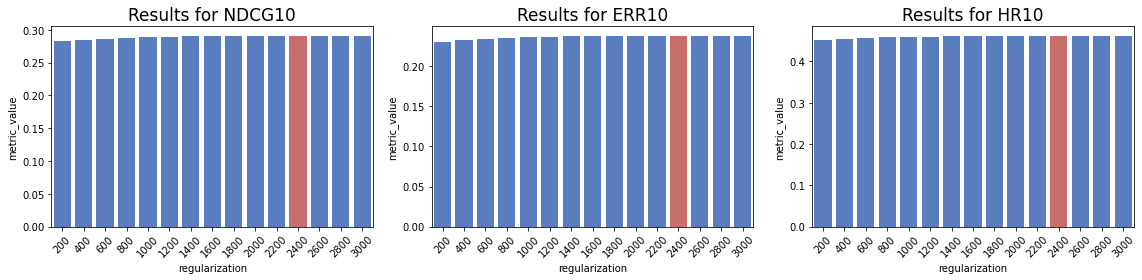

In [196]:
metrics = resdf.metric_name.unique()
fig, axes = plt.subplots(1, 3, figsize=(16,4))
sn.set_color_codes("muted")
axes = axes.ravel()
plt.xticks(rotation=45)
for i in range(len(metrics)):
    tmp = resdf[resdf.metric_name==metrics[i]]
    axes[i].set_title(f"Results for {metrics[i]}", fontsize=17)
    clrs = ["b" if (x < max(tmp.metric_value)) else "r" for x in tmp.metric_value]
    sn.barplot(y="metric_value", x="regularization", data=tmp, ax=axes[i], palette=clrs)
    axes[i].tick_params(axis='x', rotation=45)
    
fig.tight_layout()
# fig.delaxes(axes[-1])

In [197]:
tmp = resdf[resdf.metric_name=="NDCG10"] #HR10
best_params = tmp.loc[tmp.metric_value.idxmax()].regularization

# save the results
with open("/home/mmarzec12/models/ease/"+"ease_best_params", "wb") as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [187]:
best_params

2400

## CEASE

In [11]:
savepath = "D:/0Studia/Data-Science-PW\Masters-thesis\models/cease/model_tuning/"
n_files = len(glob.glob(savepath+"/*"))
res = []
for i in range(1,n_files+1):
    res.append(pd.read_pickle(savepath+f"/cease_{i}"))
    
res = res[:8]

In [12]:
res

[{'model_name': 'CEASE',
  'calculation_time': 58.32758665084839,
  'alpha': 1,
  'NDCG': 0.2906843031281639,
  'ERR': 0.23763084790343603,
  'HR': 0.4620200946059917},
 {'model_name': 'CEASE',
  'calculation_time': 59.15926814079285,
  'alpha': 5,
  'NDCG': 0.29081802365228293,
  'ERR': 0.2378566459341367,
  'HR': 0.4617725789299989},
 {'model_name': 'CEASE',
  'calculation_time': 59.368834495544434,
  'alpha': 10,
  'NDCG': 0.2908504857765701,
  'ERR': 0.23799285594965985,
  'HR': 0.4614425580286752},
 {'model_name': 'CEASE',
  'calculation_time': 59.26719307899475,
  'alpha': 50,
  'NDCG': 0.28728468458670064,
  'ERR': 0.23530173048525876,
  'HR': 0.45499798320560303},
 {'model_name': 'CEASE',
  'calculation_time': 58.62268614768982,
  'alpha': 100,
  'NDCG': 0.28386862411471925,
  'ERR': 0.2318630160068868,
  'HR': 0.45176194492317845},
 {'model_name': 'CEASE',
  'calculation_time': 58.572964668273926,
  'alpha': 500,
  'NDCG': 0.28093338707811893,
  'ERR': 0.2286615731694753,
  'H

In [8]:
resdf = pd.DataFrame(columns=["alpha", "metric_name", "metric_value"])
rows_list = []
for r in res:
    d1 = {}
    d1["alpha"] = r['alpha']
    d1["metric_name"] = "NDCG10"
    d1["metric_value"] = r["NDCG"]
    rows_list.append(d1)
    
    d2 = {}
    d2["alpha"] = r["alpha"]
    d2["metric_name"] = "ERR10"
    d2["metric_value"] = r["ERR"]
    rows_list.append(d2)
    
    d3 = {}
    d3["alpha"] = r["alpha"]
    d3["metric_name"] = "HR10"
    d3["metric_value"] = r["HR"]
    rows_list.append(d3)

    
resdf = pd.DataFrame(rows_list)

In [9]:
resdf

""


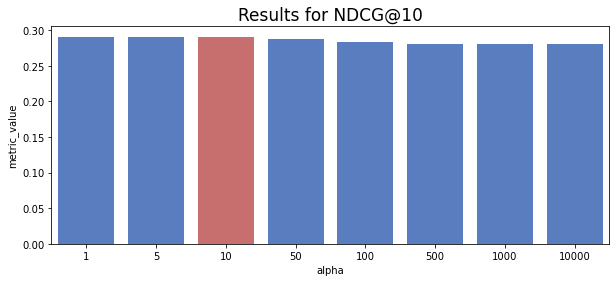

In [21]:
metrics = resdf.metric_name.unique()
sn.set_color_codes("muted")
plt.figure(figsize=(10,4))
i = 0
tmp = resdf[resdf.metric_name==metrics[i]]
plt.title(f"Results for {metrics[i][:-2]}@{metrics[i][-2:]}", fontsize=17)
clrs = ["b" if (x < max(tmp.metric_value)) else "r" for x in tmp.metric_value]
sn.barplot(y="metric_value", x="alpha", data=tmp, palette=clrs)
plt.savefig(plot_savepath+"CEASE_tuning_alpha.png")
plt.show()

In [23]:
tmp = resdf[resdf.metric_name=="NDCG10"] #HR10
best_params = tmp.loc[tmp.metric_value.idxmax()].alpha

# save the results
with open("/home/mmarzec12/models/cease/"+"cease_best_params", "wb") as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [209]:
k=10
reg=1000
gram = (train_data.T @ train_data)
ease = EASE(regularization=reg)
ease.fit(gram)
recs = ease.calculate_top_k(train_data, ids_to_gs, ids_to_us, k=k)

ev = Evaluator(k=k, true=validation_list, predicted=recs)
ev.calculate_metrics()
ndcg, err, hr = ev.ndcg, ev.err, ev.hr

  0%|          | 0/109084 [00:00<?, ?it/s]

In [210]:
ndcg, err, hr

(0.2887130122093169, 0.23580008678327405, 0.45949910160976865)

In [148]:
explicit_full = pd.read_csv(mypath+"explicit_train.csv")

In [149]:
explicit_full[explicit_full.user_name=="B41939"]

,user_name,game_id,score
4664911,B41939,12333,2.0
4664912,B41939,242,3.0
4664913,B41939,17392,6.0
4664914,B41939,132018,6.0
4664915,B41939,164949,6.0
4664916,B41939,165872,3.0
4664917,B41939,204516,5.0
4664918,B41939,234,6.0
4664919,B41939,221,6.0
4664920,B41939,55829,4.0


In [146]:
tmp = joined.groupby("user_name").count()["score"].sort_values()
tmp[tmp<=1]

user_name
B41939             1
onedollarbob       1
robertino          1
tomstart101        1
Kafkaish           1
Feelalive          1
maggico            1
suella4ever        1
AMI_SOLGER         1
Cocco_0716         1
bgrtemp95          1
knavevagrant       1
downodal           1
kwojtasz           1
commodoreKid       1
EdgarJan           1
Elmagochile        1
rabid_schnauzer    1
Avoro38            1
macrsson           1
Plebian            1
fluffystark        1
Name: score, dtype: int64

In [78]:
ease = EASE(regularization=200)
ease.fit(dense_gram)
recs = ease.calculate_top_k(train_data, ids_to_gs, ids_to_us, k=10)

  0%|          | 0/109084 [00:00<?, ?it/s]

In [80]:
ev = Evaluator(k=10, true=validation_list, predicted=recs)
ev.calculate_metrics()
ngcg10, err10, hr10 = ev.ndcg, ev.err, ev.hr

In [81]:
print(ngcg10, err10, hr10)

0.28026974230430785 0.2277629573947091 0.44992849547137986


In [118]:
tag_joined = scipy.sparse.vstack((train_data, tag_matrix))
tag_gram = tag_joined.T @ tag_joined
cease = EASE(regularization=100)
cease.fit(tag_gram)

In [121]:
tag_gram.toarray()

array([[ 2153,   597,   630, ...,    16,    70,    18],
       [  597,  5075,  1426, ...,    38,   169,    22],
       [  630,  1426, 11929, ...,    83,   188,   121],
       ...,
       [   16,    38,    83, ...,   523,    16,    34],
       [   70,   169,   188, ...,    16,  1911,    13],
       [   18,    22,   121, ...,    34,    13,   494]])

In [108]:
recs = cease.calculate_top_k(train_data, ids_to_gs, ids_to_us, k=10)

ev = Evaluator(k=10, true=validation_list, predicted=recs)
ev.calculate_metrics()
ngcg10, err10, hr10 = ev.ndcg, ev.err, ev.hr
print(ngcg10, err10, hr10)

  0%|          | 0/109084 [00:00<?, ?it/s]

0.28033384124619326 0.22784067164200825 0.44994682996589785
